In [1]:
from collections import defaultdict
from gtfslib.dao import Dao
from gtfslib.model import CalendarDate, Route, Stop, Trip
from itertools import tee
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline


def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2,s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def label(k):
    a, b = k
    aname = dao.stop(a).stop_name
    bname = dao.stop(b).stop_name
    return "{}\n{}".format(aname, bname)

In [2]:
dao = Dao()
# http://transitfeeds.com/p/sfmta/60/20170629
dao.load_gtfs("./data/SFMTA-mission-corridor.zip")

In [3]:
stop_fltr = Stop.stop_id.in_([
    # Mission corridor stop_id's
    '5547', '5551', '5553', '5557', '5561', '5565', '5567'
])

corridor = {s.stop_id for s in dao.stops(fltr=stop_fltr)}
fltr = (
    # Pick trips scheduled for a specific date
    (CalendarDate.date=="2017-08-09")
    & ((Route.route_short_name.in_(["14"])) & (Trip.direction_id=="1"))
)

def sort_corridor_start(t):
    starts = [st.arrival_time for st in t.stop_times if st.stop_id in corridor]
    return min(starts) if any(starts) else 1e6

trips = list(sorted([
    t for t in dao.trips(fltr=fltr)
    if len(corridor) == sum(1 for st in t.stop_times if st.stop_id in corridor)
], key=sort_corridor_start))

In [4]:
runtimes = defaultdict(lambda: defaultdict(list))
for trip in trips:
    for a, b in pairwise(st for st in trip.stop_times if st.stop_id in corridor):
        atime = a.departure_time or a.arrival_time
        btime = b.arrival_time or b.departure_time
        seconds = btime - atime
        meters = b.shape_dist_traveled - a.shape_dist_traveled
        kph = (meters / 1000.) / (seconds / 60. / 60.)
        key = (a.stop_id, b.stop_id)
        runtimes[key]['t'].append(atime)
        runtimes[key]['delta'].append(seconds)
        runtimes[key]['kph'].append(kph)

keys = list(sorted(runtimes.keys(), key=lambda k: min(runtimes[k]['t'])))
labels = [label(k) for k in keys]

kphs = [np.array(runtimes[key]['kph']) for key in keys]
deltas = [np.array(runtimes[key]['delta']) for key in keys]

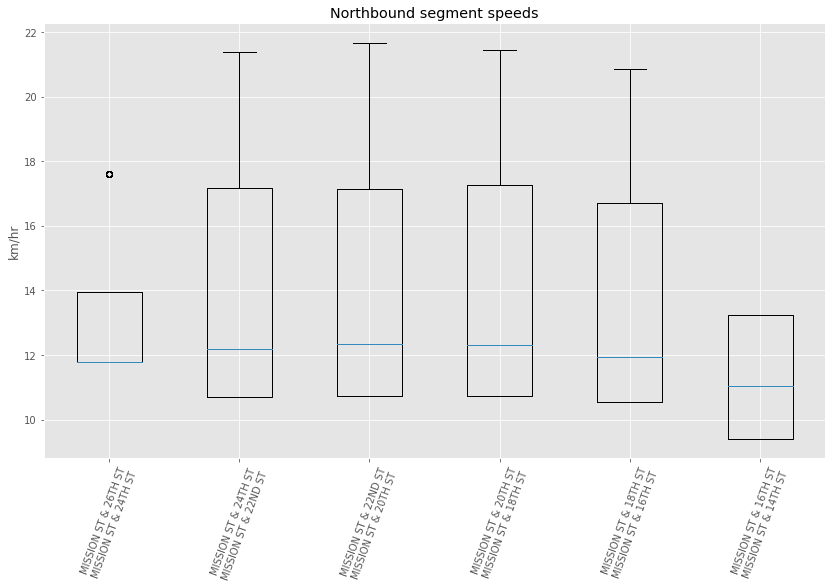

In [5]:
plt.figure(figsize=(14,8))
plt.title("Northbound segment speeds")
plt.boxplot(kphs)
plt.ylabel("km/hr")
plt.xticks(list(range(1, len(keys) + 1)),
           labels,
           rotation=70)
plt.show()

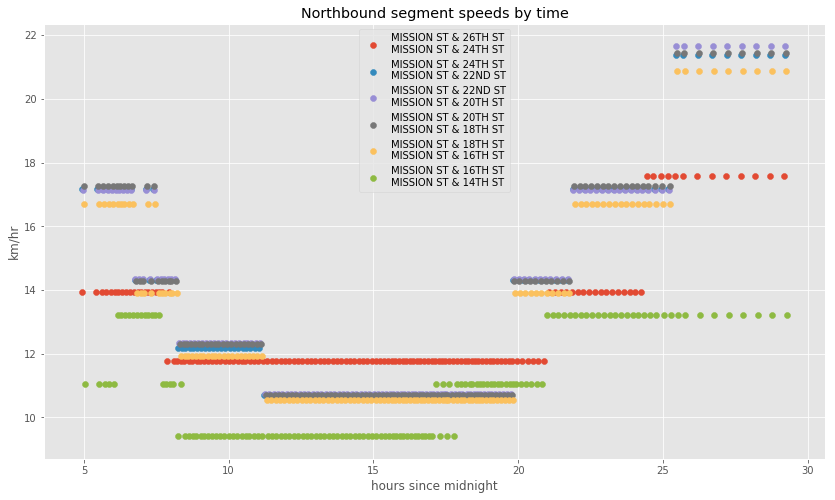

In [6]:
plt.figure(figsize=(14,8))
plt.title("Northbound segment speeds by time")
plt.ylabel("km/hr")
plt.xlabel("hours since midnight")
for key in keys:
    hours = np.array(runtimes[key]['t']) / 60. / 60.
    plt.scatter(hours, runtimes[key]['kph'])
plt.legend(labels, loc=9)
plt.show()

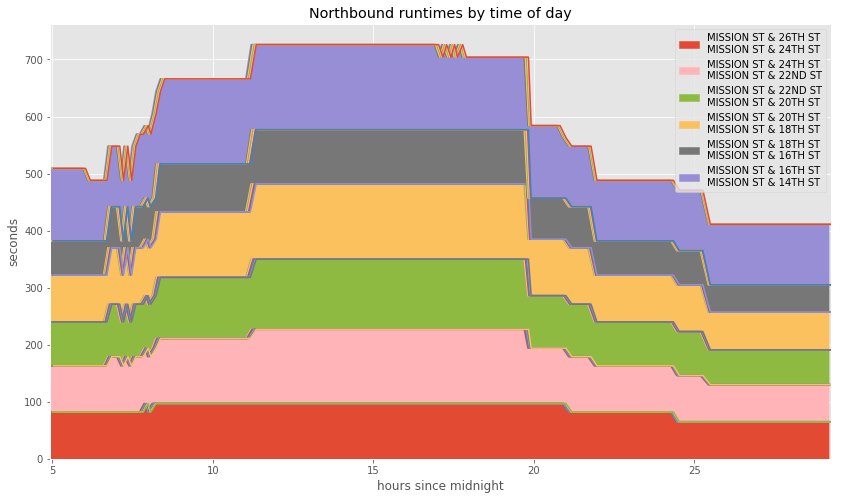

In [7]:
hours = np.transpose([np.array(runtimes[key]['t']) / 60. / 60. for key in keys])
ax = pd.DataFrame(np.transpose(deltas), index=hours).plot.area(figsize=(14,8))
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
ax.set_title("Northbound runtimes by time of day")
ax.set_xlabel("hours since midnight")
ax.set_ylabel("seconds")
plt.show()

Did you enjoy this post? Let me know on [twitter](https://twitter.com/invisiblefunnel). Also, Remix is [hiring](https://www.remix.com/jobs).